# DATASCI W207: Applied Machine Learning Fall'23 Final Project
### Using Machine Learning to Predict Real/Fake Job Postings

Section 3 12 Dec, 2023

Eshan Bhatnagar,
Fengshou Liang,
Jane Su


## Problem Motivation

The job market can be a tough place for both job seekers and companies, especially with the overwhelming number of job postings floating around on different platforms. However, there's a new issue making things even trickier – fake job postings. Just picture this: you're scrolling through job listings, trying to find the perfect opportunity, only to discover that some of them are nothing but smoke and mirrors. These fake job postings are created by companies that aren't actually looking to hire anyone. It's a real problem for the entire job market.

Fake job postings not only impact job seekers by creating a misleading impression of an inflated job market but also have broader consequences. The deception can lead to frustration and mistrust among job seekers, damaging their perception of the hiring process. Additionally, the reputation of job search platforms and the companies using them is at stake. If platforms are perceived as hosting numerous fake listings, users may lose trust, impacting the credibility of these platforms. Therefore, the successful identification of these fake job postings can be extremely helpful to improve the overall integrity of the job market and the entities involved.

In this notebook, we took a closer look at how these deceptive job ads were affecting everyone and explored some potential solutions. Luckily, with the machine learning algorithms, we were able to identify fake job descriptions based on textual information. We used a dataset from Kaggle containing approximately 18,000 job descriptions to create classification models which can help predict if job descriptions are fraudulent.


## Outline
•	Section 1: Import Statements

•	Section 2: Data cleaning and feature selection

•	Section 3: Exploratory data analysis

•	Section 4: Model 0: Baseline model accuracy

•	Section 5: Model 1: Binary Logistic Regression

•	Section 6: Model 2: Random Forest on Balanced Data

•	Section 7: Text Analysis

•	Section 8: Word Frequency

•	Section 9: Embeddings

•	Section 10: NLP Model 1: Dealing with data imbalance with Oversampling + Random Forest

•	Section 11: NLP Model 2: Dealing with data imbalance with Oversampling + Random Forest

•	Section 12: NLP Model 3: Dealing with data imbalance with Undersampling + Neural Network

• Section 13: Final Model - Applying Transformers on Complete Data

•	Section 14: Discussion of limitations and other ethical considerations

•	Section 15: Conclusion


## Import Statements

In [ ]:
!pip install transformers

In [ ]:
# standard
import pandas as pd
import numpy as np
import random
import os

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt

# ML from sklearn
import sklearn
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score

# tf, keras and torch
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import keras
from keras import metrics
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# text analysis
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

#  others
import re
from collections import Counter
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
files.upload()
df = pd.read_csv("fake_job_postings.csv")
df.head()

Saving fake_job_postings.csv to fake_job_postings.csv


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

## Data Cleaning and Feature Selection

After importing the data, we can see that there are 17 columns to examine. The first column, 'job_id' is simply an identification column for the given job entry in the data frame. The 'title' column refers to the job title or position being advertised. The 'location' column refers to the city where the job is located. The 'department' column represents the department or division within the company related to the job. The 'salary_range' column refers to the expected salary range for the position. The 'company_profile' column gives more information about the company, possibly including its history, mission, and culture. The 'description' column gives a detailed description of the job, its responsibilities, and requirements. The 'requirements' column addresses the qualifications, skills, and experience required for the job. The 'benefits' column refers to the benefits or perks associated with the job, such as health insurance, retirement plans, or other incentives. The 'telecommuting' column is a binary variable which represents whether the job is a remote position or not. The 'has_company_logo' column is another binary variable referring to whether the company's logo is present on the job posting. The 'has_questions' column is another binary variable based on whether any questions are present in the job posting. The 'employment_type' column refers to whether the position is full-time, part-time, contract, temporary, or other employment types. The 'requried_experience' column refers to the experience a candidate is expected to have for the position, whether it's an internship, entry level, executive level, etc. The 'required_education' column also refers to the amount of education an applicant is expected to have, including having a bachelor's or master's degree, being a high school graduate, etc. The 'industry' column refers to what industry the company is in, such as marketing, health care, computer software, etc. The 'function' column is more specific to the type of work the position will involve, such as customer service or sales. Finally, the 'fraudulent' column is our target variable. This is a binary variable on whether the given job posting is real or fraudulent, and we will be using multiple machine learning classification models to predict this variable.  


The first two models we will be using are a simple logistic regression and a random forest. Therefore, a majority of the text-based columns can be dropped as they are too descriptive and varied. Additionally, all rows with null values will also be dropped to further clean the data. The resulting features we will use for the models include 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', and 'function'.

In [ ]:
# drop department because of many missing values, drop first couple of columns because they are too descriptive and varied
df1=df.drop(["department","job_id","title","location","salary_range","company_profile","description","requirements","benefits"],axis=1)
df_clean=df1.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7615 entries, 3 to 17878
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   telecommuting        7615 non-null   int64 
 1   has_company_logo     7615 non-null   int64 
 2   has_questions        7615 non-null   int64 
 3   employment_type      7615 non-null   object
 4   required_experience  7615 non-null   object
 5   required_education   7615 non-null   object
 6   industry             7615 non-null   object
 7   function             7615 non-null   object
 8   fraudulent           7615 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 594.9+ KB


## Exploratory Data Analysis

In [ ]:
df_clean['fraudulent'].value_counts()

0    7273
1     342
Name: fraudulent, dtype: int64

0    7273
1     342
Name: fraudulent, dtype: int64


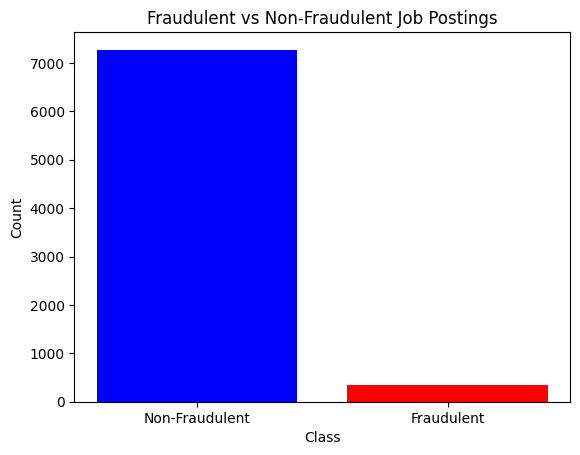

0.047023236628626425


In [ ]:
print(df_clean['fraudulent'].value_counts())

data = {'Non-Fraudulent': 7273, 'Fraudulent': 342}

fraudulent_data = list(data.values())
labels = list(data.keys())

plt.bar(labels, fraudulent_data, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Fraudulent vs Non-Fraudulent Job Postings')

plt.show()
print(342/7273)

After cleaning the data, we can see that only 342 posts or approximately 4.7% of the data are labeled fake. This indicates that distribution is highly imbalanced, so accuracy may not be sufficient enough to evaluate the models. Precision and recall will be used in addition for model evaluation as they can evaluate the models' effectiveness in identifying false positives and false negatives for both classes. Precision and recall can be evaluated using the AUC metric, which refers to the area under the precision recall curve. Additionally, solutions to balance the data will also be implemented for some of the models.

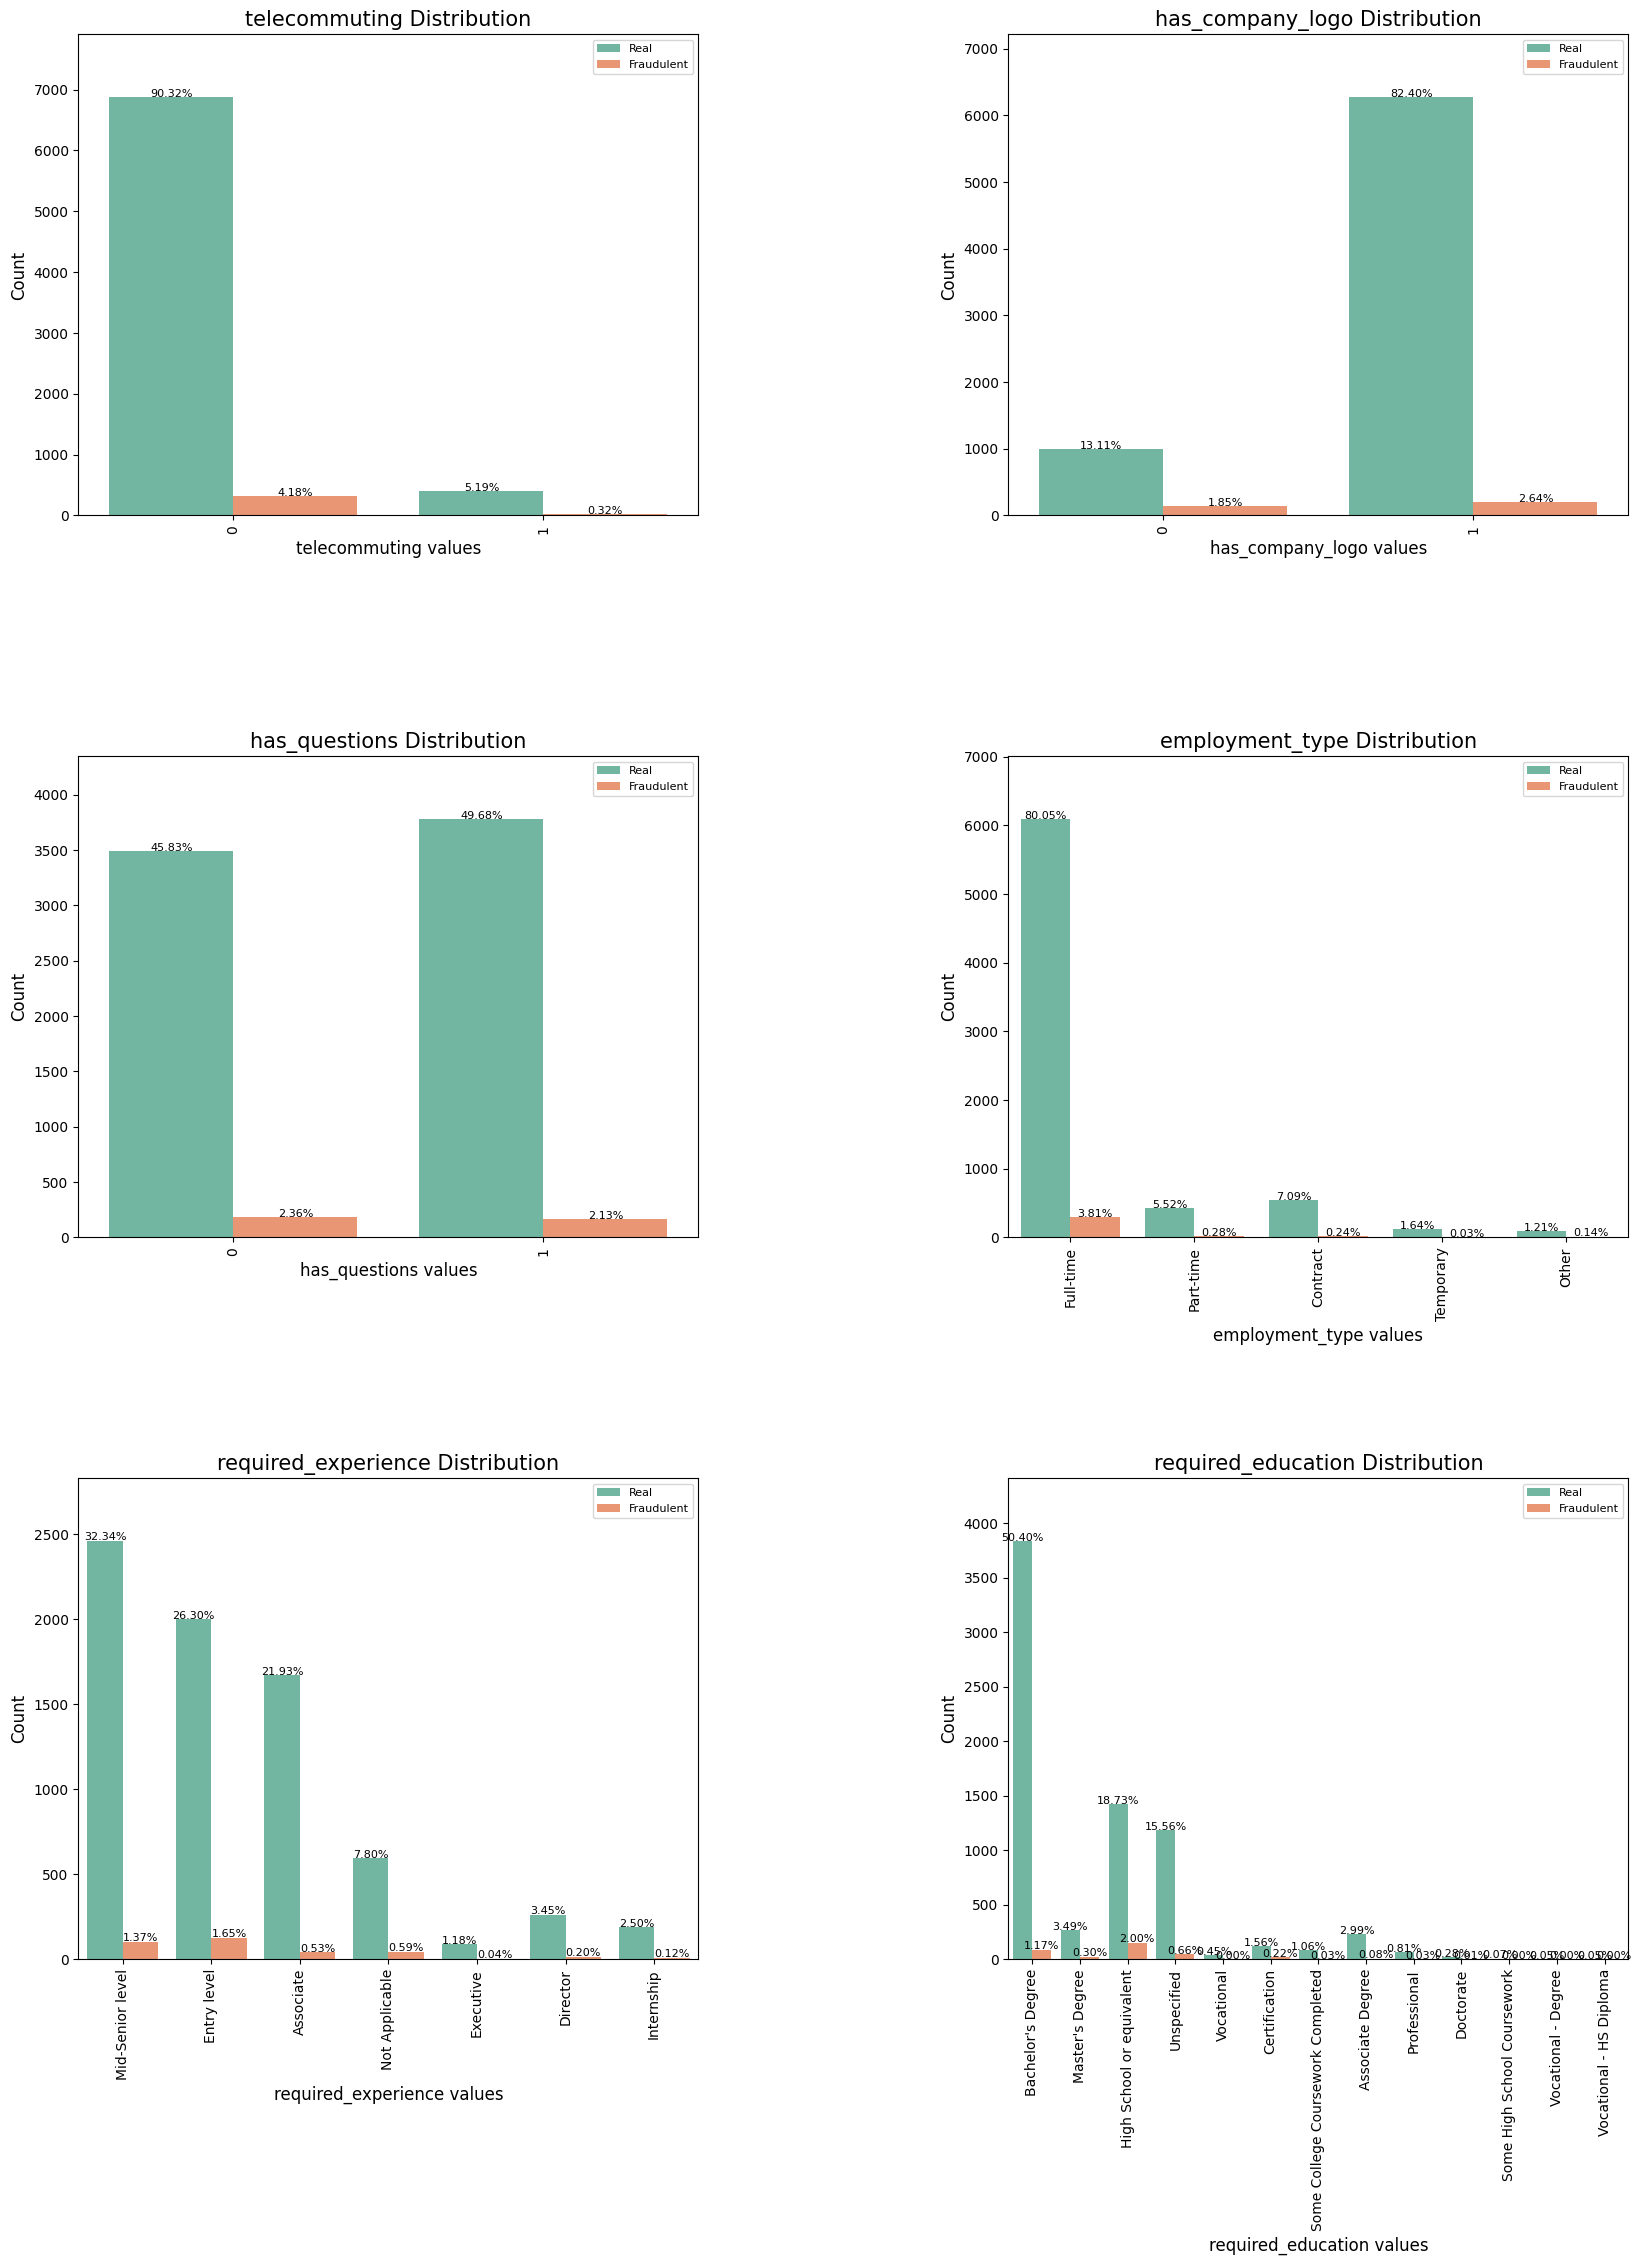

In [ ]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education"]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 2, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(20,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(df_clean[cat_cols]):
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=df_clean, hue='fraudulent', palette='Set2')
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels()
    ylabels = ax.get_yticklabels()
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(labels=['Real', 'Fraudulent'], fontsize=8)
    plt.xticks(rotation=90)
    total = len(df_clean)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=8)
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()

We can use the bar plots of the distributions of each of the key features to do more exploratory data analysis in comparing the real and fraudulent job postings. For telecommuting, both targets follow a distribution where a majority of the telecommuting values are 0. A larger proportion of the data has a company logo for both targets as well, although a much larger proportion of the real job postings have a company logo compared to that of the fraudulent postings. For both targets, the distribution of having or not having questions is roughly equal, although for real postings, the proportion of having questions is slightly larger whereas the opposite is true for the fraudulent postings. For employment type, the majority of the distribution for both targets is full-time, while contract also has the second highest count for real postings. For fraudulent postings however, part-time has the second highest count instead. For experience level, the highest count for real postings is attributed to mid-senior level positions, whereas for fraudulent postings, the highest count is attributed to entry level roles. For required education, the highest count for real postings is attributed to Bachelor's degree, whereas for fraudulent postings, it's attributed to high school or equivalent. Overall, the required experience and education features seem to indicate the biggest discrepancy between the real and fraudulent postings and may be the most significant features to examine in the training model. On the other hand, the telecommuting feature has a similar distribution for both targets, and since the majority of values are 0, it may not be a helpful feature and can be dropped.

In [ ]:
df_clean=df_clean.drop(["telecommuting"],axis=1)
df_clean.head()

,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
3,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
6,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
9,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0
10,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0


## Model 0: Baseline model accuracy

In [ ]:
# assume model only returns 0 for all inputs, accuracy is:
7273/(7273+342)

0.9550886408404465

With the given counts for real and fake job postings from the cleaned data, our baseline accuracy is approximately 95.5089%. We will try to improve upon this accuracy with our classification models, which include logistic regression, random forest, neural networks, and transformers.

## Model 1: Binary Logistic Regression

Before running the logistic regression model, we will first use one hot encoding for the features being used, including employment type, required experience, required education, industry, and function.

In [ ]:
one_hot_encoded_data = pd.get_dummies(df_clean, columns = ['employment_type', 'required_experience',"required_education","industry","function"])
one_hot_encoded_data.columns
df_final=one_hot_encoded_data.copy()

In [ ]:
X= df_final.drop(['fraudulent'],axis=1)
y=df_final['fraudulent']

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [ ]:
X_train.head()

,has_company_logo,has_questions,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,required_experience_Associate,required_experience_Director,required_experience_Entry level,...,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
12776,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1696,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10088,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
911,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def build_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """

  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[metrics.binary_accuracy])

  return model

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

Epoch 1/10
86/86 [==============================] - 1s 5ms/step - loss: 0.4366 - binary_accuracy: 0.9464 - val_loss: 0.3293 - val_binary_accuracy: 0.9590
Epoch 2/10
86/86 [==============================] - 0s 3ms/step - loss: 0.2927 - binary_accuracy: 0.9546 - val_loss: 0.2494 - val_binary_accuracy: 0.9590
Epoch 3/10
86/86 [==============================] - 0s 3ms/step - loss: 0.2398 - binary_accuracy: 0.9546 - val_loss: 0.2146 - val_binary_accuracy: 0.9590
Epoch 4/10
86/86 [==============================] - 0s 3ms/step - loss: 0.2147 - binary_accuracy: 0.9546 - val_loss: 0.1962 - val_binary_accuracy: 0.9590
Epoch 5/10
86/86 [==============================] - 0s 3ms/step - loss: 0.2008 - binary_accuracy: 0.9546 - val_loss: 0.1855 - val_binary_accuracy: 0.9590
Epoch 6/10
86/86 [==============================] - 0s 3ms/step - loss: 0.1924 - binary_accuracy: 0.9546 - val_loss: 0.1787 - val_binary_accuracy: 0.9590
Epoch 7/10
86/86 [==============================] - 0s 3ms/step - loss: 0.18

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.436637,0.946370,0.329258,0.959016
1,0.292700,0.954579,0.249367,0.959016
2,0.239806,0.954579,0.214579,0.959016
3,0.214737,0.954579,0.196236,0.959016
4,0.200833,0.954579,0.185493,0.959016
5,0.192432,0.954579,0.178653,0.959016
6,0.186949,0.954579,0.174075,0.959016
7,0.183211,0.954579,0.170856,0.959016
8,0.180535,0.954579,0.168546,0.959016
9,0.178572,0.954579,0.166787,0.959016


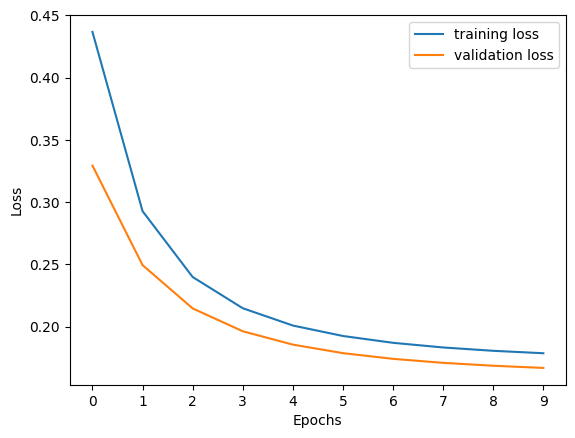

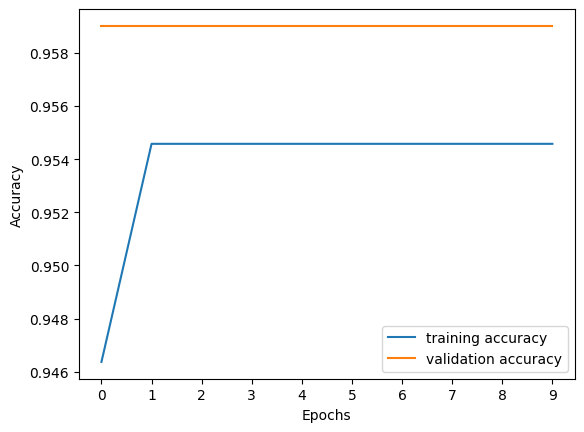

48/48 [==============================] - 0s 2ms/step
Test accuracy:  0.9553512930870056
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1455
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1523
   macro avg       0.48      0.50      0.49      1523
weighted avg       0.91      0.96      0.93      1523

AUC score : 0.5


In [ ]:
model = build_model(learning_rate=0.01)

num_epochs = 10
# Fit the model.
history = model.fit(
  x = X_train,   # our binary training examples
  y = y_train,   # corresponding binary labels
  epochs=num_epochs,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
results = pd.DataFrame(history.history)
display(results)

#plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xticks(range(num_epochs))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot the train and validation accuracy
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#apply the model to test data and get the accuracy
y_pred=model.predict(X_test)
test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']
print("Test accuracy: ", test_accuracy)

y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))
print ("AUC score :", np.round(roc_auc_score(y_test, y_pred),5))

After training and testing the logistic regression, we can see that the model returns a test accuracy of approximately 95.535%. It shows a high level of accuracy in identifying legitimate job postings and performs slightly better than the baseline in evaluating the test data. However, when training the model, although the binary loss and validation loss gradually decreased with each epoch, the training accuracy and validation accuracy appeared to remain constant after the first epoch. This may indicate that the model is overfitting the data, and perhaps may not be the best classification model to use. Additionally, the model returns an AUC score of 0.5, which indicates low precision and recall, especially for the fraudulent class where the precision and recall scores are 0.

## Model 2: Random Forest on Balanced Data

For our second model, we will use a random forest. This is one of the most effective models for classification. However, since this is a decision tree model, it may not be perfectly suited to our currently skewed class distribution where approximately 95% of the data accounts for real job postings. Our solution to balance the data was to use Synthetic Minority Over-sampling Technique (SMOTE). This is an oversampling technique that generates synthetic examples of the minority class (fraudulent job postings) to balance the class distribution.

In [ ]:
#using SMOTE to handle imbalanced data
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
y_resampled.value_counts()

0    7273
1    7273
Name: fraudulent, dtype: int64

In [ ]:
# using the train test split function on the resampled data
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_resampled,y_resampled,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

X_train_rs, X_val_rs, y_train_rs, y_val_rs = train_test_split(X_train_rs,y_train_rs,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

We can now use the random forest model with our balanced data. We will test the model with two hyperparameter tuning methods, random search and grid search. We must first define a parameter grid of hyperparameter values that can be used to build the model. Grid search will then place these hyperparameters in a matrix and exhaustively train on every combination of hyperparameter values before selecting the model with the best performance. On the other hand, random search randomly samples from a grid of hyperparameters instead of exhaustively training each combination. The hyperparameters we will use include the following:

* max_depth: This represents the maximum level of each tree in the random forest model. A deeper tree will be able to capture more information on the training data but may not generalize well for test data, possibly indicating overfitting.
* n_estimators: This represents the number of decision trees in the forest.
* max_features: This represents the maximum number of features the random forest can try at each split.
* min_samples_leaf: This represents the minimum number of samples required to be at each leaf node of each decision tree.
* min_samples_split: This is the minimum number of samples required to split an internal node of each tree.


In [ ]:
rf = RandomForestClassifier()
#random search
from scipy.stats import randint
# random search cv
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(100, 500, step=100),
              'max_features':randint(1,7),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
          }

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(rf, rs_space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train_rs,y_train_rs)

# random random search results
print('Best random search hyperparameters are: '+str(model_random.best_params_))
print('Best random search score is: '+str(model_random.best_score_))

Best random search hyperparameters are: {'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
Best random search score is: 0.9669990125483604


In [ ]:
#rf model using random search hyperparameters
from sklearn.metrics import accuracy_score, precision_score, recall_score

random_rf = RandomForestClassifier(max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=300)
random_rf.fit(X_train_rs, y_train_rs)
y_pred_train = random_rf.predict(X_train_rs)
y_pred_val = random_rf.predict(X_val_rs)
y_pred_test = random_rf.predict(X_test_rs)

print("Train accuracy: ", accuracy_score(y_train_rs, y_pred_train))
print("Train precision: ", precision_score(y_train_rs, y_pred_train))
print("Train recall: ", recall_score(y_train_rs, y_pred_train))

print("Validation accuracy: ", accuracy_score(y_val_rs, y_pred_val))
print("Validation precision: ", precision_score(y_val_rs, y_pred_val))
print("Validation recall: ", recall_score(y_val_rs, y_pred_val))

print("Test accuracy: ", accuracy_score(y_test_rs, y_pred_test))
print("Test precision: ", precision_score(y_test_rs, y_pred_test))
print("Test recall: ", recall_score(y_test_rs, y_pred_test))
print(classification_report(y_test_rs, y_pred_test))

y_pred_test = np.round(y_pred_test).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_test_rs, y_pred_test),5))

Train accuracy:  0.979372582724538
Train precision:  0.9768773865082733
Train recall:  0.9822952218430034
Validation accuracy:  0.9634879725085911
Validation precision:  0.9560723514211886
Validation recall:  0.9702797202797203
Test accuracy:  0.9701030927835051
Test precision:  0.9592944369063772
Test recall:  0.981263011797363
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1469
           1       0.96      0.98      0.97      1441

    accuracy                           0.97      2910
   macro avg       0.97      0.97      0.97      2910
weighted avg       0.97      0.97      0.97      2910

AUC score : 0.97021


In [ ]:
# grid search cv
grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

grid = GridSearchCV(rf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train_rs,y_train_rs)

# grid search results
print('Best grid search hyperparameters are: '+str(model_grid.best_params_))
print('Best grid search score is: '+str(model_grid.best_score_))

Best grid search hyperparameters are: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
Best grid search score is: 0.9663976158988179


In [ ]:
#rf model using grid search hyperparameters
grid_rf = RandomForestClassifier(max_depth=None, max_features=1, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
grid_rf.fit(X_train_rs, y_train_rs)
y_pred_train = grid_rf.predict(X_train_rs)
y_pred_val = grid_rf.predict(X_val_rs)
y_pred_test = grid_rf.predict(X_test_rs)

print("Train accuracy: ", accuracy_score(y_train_rs, y_pred_train))
print("Train precision: ", precision_score(y_train_rs, y_pred_train))
print("Train recall: ", recall_score(y_train_rs, y_pred_train))

print("Validation accuracy: ", accuracy_score(y_val_rs, y_pred_val))
print("Validation precision: ", precision_score(y_val_rs, y_pred_val))
print("Validation recall: ", recall_score(y_val_rs, y_pred_val))

print("Test accuracy: ", accuracy_score(y_test_rs, y_pred_test))
print("Test precision: ", precision_score(y_test_rs, y_pred_test))
print("Test recall: ", recall_score(y_test_rs, y_pred_test))
print(classification_report(y_test_rs, y_pred_test))

y_pred_test = np.round(y_pred_test).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_test_rs, y_pred_test),5))

Train accuracy:  0.9810915341641598
Train precision:  0.9917175239755885
Train recall:  0.9705631399317406
Validation accuracy:  0.9656357388316151
Validation precision:  0.9707964601769912
Validation recall:  0.958916083916084
Test accuracy:  0.9721649484536082
Test precision:  0.9715672676837726
Test recall:  0.9722414989590562
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1469
           1       0.97      0.97      0.97      1441

    accuracy                           0.97      2910
   macro avg       0.97      0.97      0.97      2910
weighted avg       0.97      0.97      0.97      2910

AUC score : 0.97217


Running the random forest models with the optimized hyperparameters from both the random search and grid search approach gave roughly similar results, although the results from grid search are slightly higher. Although grid search is not as efficient as random search, it is more likely to find the optimal hyperparameters to use for the model through testing every combination in the hyperparameter space. The training, validation, and test data gave much higher results for accuracy, precision, and recall compared to the logistic regression model as well as the baseline, indicating the effectiveness of using random forest for the binary and one hot encoded data. We can now try using more comprehensive models that utilize the text data as features.

## Text Analysis

A few of the text variables are kept for additional text analysis:

*   title: The job title or position being advertised.
*   location: The location or place where the job is located.
*   department: The department or division within the company related to the job.
*   company_profile: Information about the company, possibly including its history, mission, and culture.
*   description: A detailed description of the job, its responsibilities, and requirements.
*   requirements: The qualifications, skills, and experience required for the job.
*   benefits: The benefits or perks associated with the job, such as health insurance, retirement plans, or other incentives.
*   employment_type: The type of employment, such as full-time, part-time, contract, or temporary.
*   required_experience: The level of experience (e.g., entry-level, mid-level, senior) expected for the job.
required_education: The minimum educational qualifications or degrees required for the job.
*   industry: The industry or sector to which the company belongs (e.g., technology, healthcare, finance).
*   function: The specific function or role of the job within the company (e.g., marketing, engineering, sales).
*   fraudulent: A binary variable indicating whether the job posting is fraudulent (1) or legitimate (0).

Missing values can cause issues when we're working with the data, such as errors during analysis or when training machine learning models. Filling in missing values with blank spaces here can help mitigate these issues. The data is then subsetted into two based on whether the job posting is potentially fraudulent or legitimate.

In [ ]:
df_text = df[['title', 'location', 'department',
       'company_profile', 'description', 'requirements', 'benefits',
       'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']]
df_text = df_text.fillna(' ')

In [ ]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

columns_to_process = ['title', 'location', 'department',
       'company_profile', 'description', 'requirements', 'benefits',
       'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for column in columns_to_process:
    df_text[column] = df_text[column].apply(preprocessor)

df_text_fraud = df_text.loc[df_text.fraudulent == 1]
df_text_real = df_text.loc[df_text.fraudulent == 0]

In [ ]:
nltk.download('stopwords')

# Define a list of stop words
stop_words = set(stopwords.words('english'))
stop_words.add('level') # adding another word that appears frequently but doesn't add much value in analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_top_words(column, n=10):
    if column.dtype == 'object':
        words = [word for word in itertools.chain(*column.str.split()) if word.lower() not in stop_words]
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(n))
        return top_words
    else:
        return {}

# Get the top words for each category
top_words_fraud = {}
top_words_real = {}

for column in df_text_fraud.columns:
    top_words_fraud[column] = get_top_words(df_text_fraud[column])

for column in df_text_real.columns:
    top_words_real[column] = get_top_words(df_text_real[column])

The text data is then processed from two categories of job postings (fraudulent and legitimate) to identify the most common words in each category. This information can be useful as we will be able to understand the key terms used in each category or identifying potential indicators of fraudulent job postings.

## Word Frequency

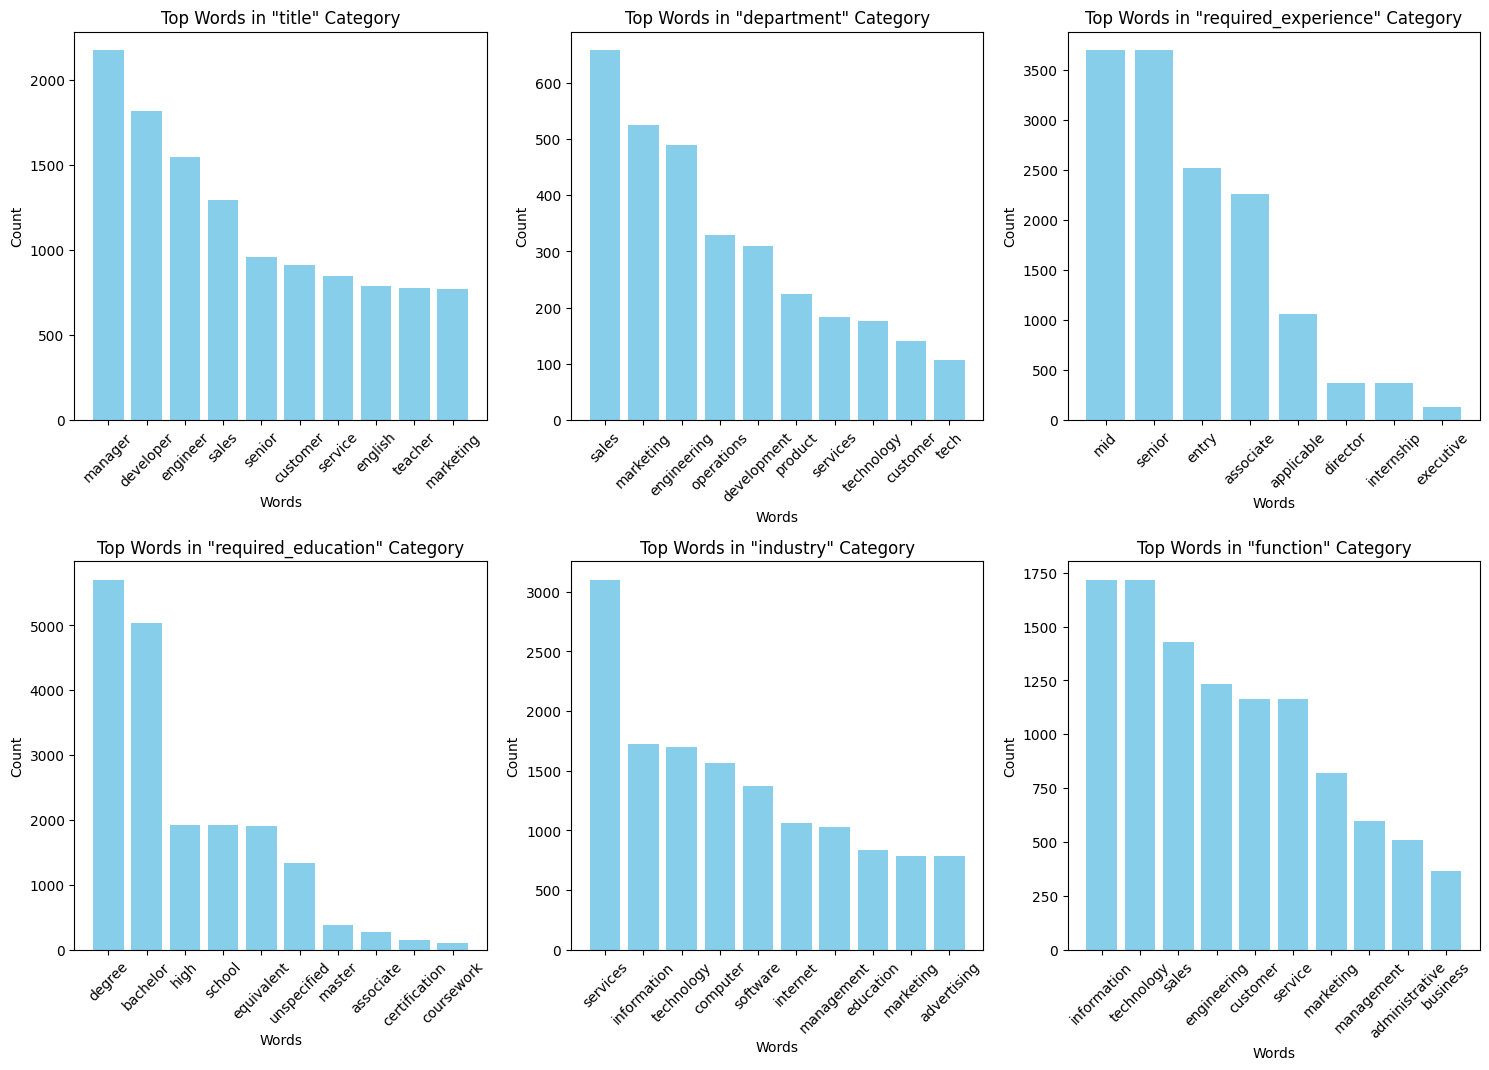

In [ ]:
# Create subplots for each category (3 in a row)
top_words_real = {key: value for key, value in top_words_real.items() if key not in ['fraudulent', 'location',
                                                                                     'company_profile', 'benefits',
                                                                                    'employment_type', 'description',
                                                                                    'requirements']}
categories = list(top_words_real.keys())
num_categories = len(categories)
num_plots_per_row = 3

fig, axes = plt.subplots(
    num_categories // num_plots_per_row + 1, num_plots_per_row,
    figsize=(15, 5 * (num_categories // num_plots_per_row + 1)))

for i, (category, values) in enumerate(top_words_real.items()):
    words = list(values.keys())
    counts = list(values.values())

    ax = axes[i // num_plots_per_row, i % num_plots_per_row]
    ax.bar(words, counts, color='skyblue')
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    ax.set_title(f'Top Words in "{category}" Category')

    # Rotate the x-axis labels to 45 degrees
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for i in range(len(categories), len(axes.ravel())):
    fig.delaxes(axes.ravel()[i])

plt.tight_layout()
plt.show()

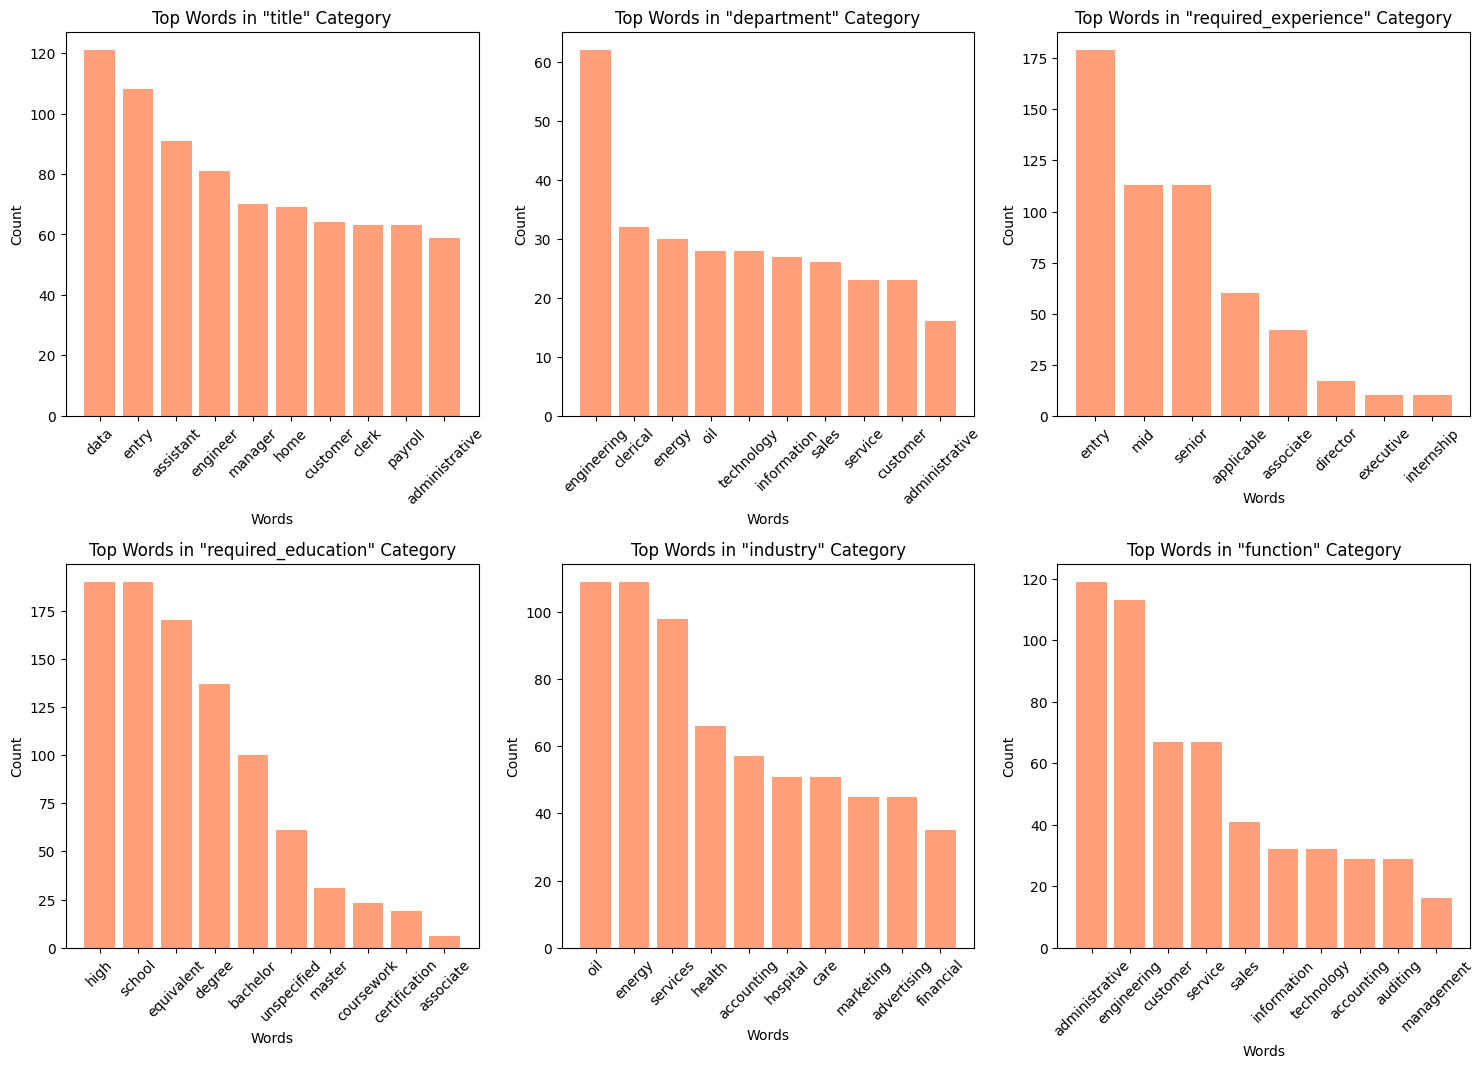

In [ ]:
# Create subplots for each category (3 in a row)
top_words_fraud = {key: value for key, value in top_words_fraud.items() if key not in ['fraudulent', 'location',
                                                                                     'company_profile', 'benefits',
                                                                                    'employment_type', 'description',
                                                                                    'requirements']}
categories = list(top_words_fraud.keys())
num_categories = len(categories)
num_plots_per_row = 3

fig, axes = plt.subplots(
    num_categories // num_plots_per_row + 1, num_plots_per_row,
    figsize=(15, 5 * (num_categories // num_plots_per_row + 1)))

for i, (category, values) in enumerate(top_words_fraud.items()):
    words = list(values.keys())
    counts = list(values.values())

    ax = axes[i // num_plots_per_row, i % num_plots_per_row]
    ax.bar(words, counts, color='#FFA07A')
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    ax.set_title(f'Top Words in "{category}" Category')

    # Rotate the x-axis labels to 45 degrees
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for i in range(len(categories), len(axes.ravel())):
    fig.delaxes(axes.ravel()[i])

plt.tight_layout()
plt.show()

Potentially fraudulent job postings often contain terms associated with low-skill or entry-level positions, while legitimate job postings have a more diverse range of experience requirements.

The industries and functions associated with potentially fraudulent job postings are more varied, such as 'oil,' 'energy,' 'services,' 'health,' and 'accounting', whereas legitimate job postings are concentrated in specific industries and functions such as 'services,' 'information,' 'technology,' and 'computer'.

Specific words in job titles, departments, and educational requirements can help distinguish potentially fraudulent postings from legitimate ones. For instance, fraudulent job postings have most of the required eduation as in high school, while legitimate postings a degreed education.

## Embeddings

In [ ]:
df_text['text_analysis'] = df_text['company_profile'] + ' ' + \
                           df_text['benefits'] + ' ' + \
                           df_text['description'] + ' ' + \
                           df_text['requirements']
df_text_analysis = df_text[[ 'text_analysis','fraudulent', ]]

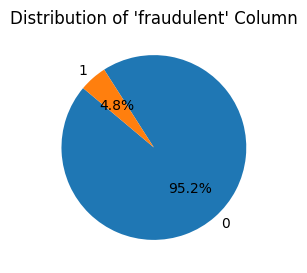

In [ ]:
# Count the values in the "fraudulent" column
value_counts = df_text_analysis['fraudulent'].value_counts(dropna=False)

plt.figure(figsize=(3, 3))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of 'fraudulent' Column")
plt.show()


## NLP Model 1: Dealing with data imbalance with Oversampling + Random Forest

In [ ]:
# Split the data into features and labels
X = df_text_analysis['text_analysis']
y = df_text_analysis['fraudulent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text data preprocessing - you can customize this as needed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Resample the training data using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train a classification model (Random Forest in this example)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))

y_pred = np.round(y_pred).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_test, y_pred),5))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.99      0.65      0.78       181

    accuracy                           0.98      3576
   macro avg       0.99      0.82      0.89      3576
weighted avg       0.98      0.98      0.98      3576

AUC score : 0.82306


The text data is preprocessed using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. We created a TF-IDF vectorizer with a maximum of 5000 features and it converts text data into numerical vectors, where each word's importance is weighted based on its frequency and rarity.

To address the class imbalance problem, we applied Synthetic Minority Over-sampling Technique (SMOTE), which generates synthetic examples of the minority class (fraudulent job postings) to balance the class distribution.

Random Forest algorithm is chosen for its ability to handle both numerical and text data effectively.

The results show a high level of accuracy and effectiveness in identifying legitimate job postings, but there is some room for improvement in detecting potentially fraudulent job postings, particularly in terms of recall. A low recall score means it's not as effective at identifying all potentially fraudulent postings. However, it has high precision, which means that when it predicts a job posting as potentially fraudulent, it's usually correct. The AUC score of 0.82306 indicates good discrimination ability, but there is room for improvement, especially in recall for fraud job postings if that is a critical concern.

## NLP Model 2: Dealing with data imbalance with Undersampling + Neural Network

An alternative would be dealing with data imbalance with undersampling the majority class.

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Separate the data into two DataFrames based on the class
df_majority = df_text_analysis[df_text_analysis['fraudulent'] == 0]
df_minority = df_text_analysis[df_text_analysis['fraudulent'] == 1]

# Undersample the majority class to match the count of the minority class
n_samples = len(df_minority)
df_majority_undersampled = resample(df_majority, n_samples=n_samples, replace=False, random_state=42)

# Create a new DataFrame with balanced classes
df_text_analysis_undersample = pd.concat([df_majority_undersampled, df_minority])

# Verify the class distribution
df_text_analysis_undersample['fraudulent'].value_counts()

0    866
1    866
Name: fraudulent, dtype: int64

In [ ]:
# define target
target = df_text_analysis_undersample.copy().pop('fraudulent') # .pop removes sentiment col from df
# target and review combined tensors
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_text_analysis_undersample[['text_analysis']].values, target.values)
)


In [ ]:
# set random seed
tf.random.set_seed(1)

# define splits for training, validation, test
splits=[0.6, 0.2, 0.2]

# shuffle data
data_tf = data_tf.shuffle(
    df_text_analysis_undersample.shape[0], reshuffle_each_iteration=False)

data_tf_test = data_tf.take(int(df_text_analysis_undersample.shape[0]*splits[2]))
data_tf_train_valid = data_tf.skip(int(df_text_analysis_undersample.shape[0]*splits[2]))
data_tf_train = data_tf_train_valid.take(int(df_text_analysis_undersample.shape[0]*splits[0]))
data_tf_valid = data_tf_train_valid.skip(int(df_text_analysis_undersample.shape[0]*splits[0]))

In [ ]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)

print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 18925


In [ ]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

In [ ]:
# define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label],
                          Tout=(tf.int64, tf.int64))

In [ ]:
# the encode_map_fn is defined at the top of the notebook
data_tf_train = data_tf_train.map(encode_map_fn)
data_tf_valid = data_tf_valid.map(encode_map_fn)
data_tf_test = data_tf_test.map(encode_map_fn)

In [ ]:
# define batch size
batch_size = 32

# batcing of training, validation and test partitions
train_data = data_tf_train.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

valid_data = data_tf_valid.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

test_data = data_tf_test.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

Average sequence length in training mini-batches: 895


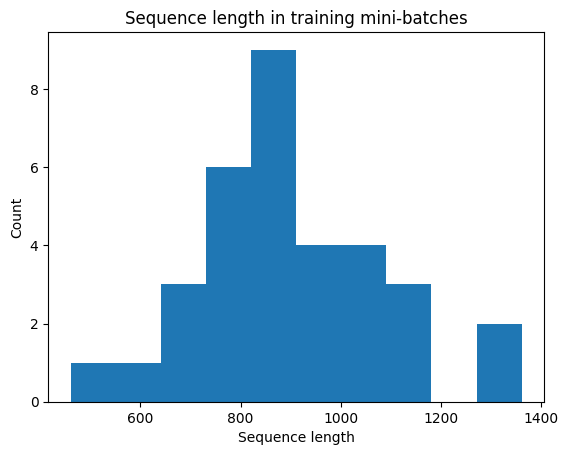

In [ ]:
# histogram of sequence length in training mini-batches
seq_len_train = []
for batch in train_data:
    seq_len_train.append(batch[0].shape[1])

print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)

# histogram
plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length');

Afetr undersampling the majority class and preprocessing the text data, we are prepared to have it ready for training the classification model. The data is then split into training, validation, and test sets.

In [ ]:
# Embed our training vocabulary into 10 dimensions.
vocab_size_train = len(token_counts) + 2
embedding_dim = 20

embedding_layer = tf.keras.layers.Embedding(
    vocab_size_train,
    embedding_dim,
)

In [ ]:
vocab_size_train = len(token_counts) + 2
embedding_dim = 20

model = tf.keras.Sequential()
# add embedding layer (this is our imput layer)
# embeddings will be learned during training
# the weights for the embeddings are randomly initialized (just like any other layer!)
model.add(Embedding(
    vocab_size_train,
    embedding_dim,
    #input_length=100, #limits length of sentence to 100 tokens
    name="embedding")
    ),


# average over the emedding dimension, so each review is represented by a 1 vector of size embedding_dimension
model.add(GlobalAveragePooling1D()),

# add a Dense layer of dimension 16
model.add(Dense(16, activation='relu')),

# add Dropout for regularization
model.add(Dropout(0.5))

# add last layer (binary classification task)
model.add(Dense(1, activation='sigmoid'))


# save embeddings before training
embeddings_untrained = model.get_layer('embedding').get_weights()[0]

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          378540    
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             (None, 16)                336       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 378893 (1.45 MB)
Trainable params: 378893 (1.45 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [ ]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15)

Epoch 1/15
33/33 [==============================] - 12s 253ms/step - loss: 0.6929 - accuracy: 0.5294 - precision: 0.5455 - recall: 0.2918 - auc: 0.5148 - val_loss: 0.6912 - val_accuracy: 0.6772 - val_precision: 0.8333 - val_recall: 0.4167 - val_auc: 0.6521
Epoch 2/15
33/33 [==============================] - 2s 47ms/step - loss: 0.6892 - accuracy: 0.5977 - precision: 0.6644 - recall: 0.3774 - auc: 0.6636 - val_loss: 0.6868 - val_accuracy: 0.7378 - val_precision: 0.7852 - val_recall: 0.6310 - val_auc: 0.7617
Epoch 3/15
33/33 [==============================] - 2s 47ms/step - loss: 0.6842 - accuracy: 0.6352 - precision: 0.6573 - recall: 0.5486 - auc: 0.6867 - val_loss: 0.6790 - val_accuracy: 0.7493 - val_precision: 0.7516 - val_recall: 0.7202 - val_auc: 0.7902
Epoch 4/15
33/33 [==============================] - 2s 48ms/step - loss: 0.6735 - accuracy: 0.6603 - precision: 0.7028 - recall: 0.5428 - auc: 0.7380 - val_loss: 0.6674 - val_accuracy: 0.7666 - val_precision: 0.7881 - val_recall: 0.7

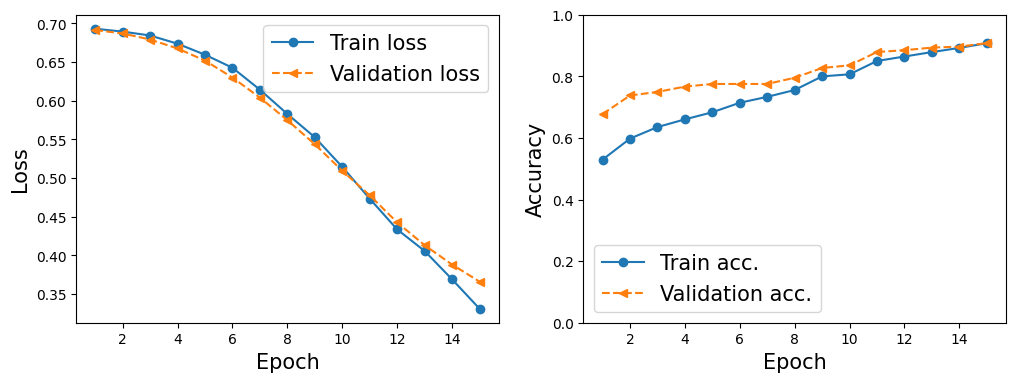

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [ ]:
print('After training this model for 15 epochs, evaluation on the validation data shows an accuracy of:')
print(np.round(hist['val_accuracy'][-1]*100,2), '%')

After training this model for 15 epochs, evaluation on the validation data shows an accuracy of:
90.78 %


In [ ]:
test_results = model.evaluate(test_data)
print(test_results)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))
print('\nAUC. {:.2f}%'.format(test_results[4]*100))

11/11 [==============================] - 0s 34ms/step - loss: 0.3965 - accuracy: 0.8757 - precision: 0.9172 - recall: 0.8424 - auc: 0.9505
[0.3965362012386322, 0.8757225275039673, 0.9171597361564636, 0.842391312122345, 0.9504830241203308]

Test Acc. 87.57%

AUC. 95.05%


The sequential model is trained over 15 epochs, with each epoch comprising 33 steps. It shows significant improvement in performance over the epochs. The training accuracy reaches 91.43%, and the validation accuracy reaches 92.22% by the end of training.

Overall, the model appears to be well-designed and trained effectively for the given text classification task. Its strong performance on both training and validation data indicates its ability to make accurate predictions. In summary, the model appears to be performing well after 15 epochs, with good accuracy, precision, recall, and AUC.

## NLP Model 3: Applying Transformers on Undersampled Data

A transformer is a type of neural network architecture used for various natural language processing tasks. It's known for its ability to handle sequential data efficiently, including text, audio, and more.They rely on a mechanism called self-attention, which allows them to weigh the importance of different elements in a sequence when making predictions.

BERT is a specific pre-trained transformer model that has been fine-tuned for various NLP tasks. It understands the context of words in a sentence by considering the words that come before and after each word. This bidirectional understanding of language allows it to capture complex relationships between words.

In this case, a pre-trained BERT model is used for fine-tuning to classify job postings (on undersampling dataset) as either fraudulent or legitimate.

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
df_text_analysis_undersample['fraudulent'] = label_encoder.fit_transform(df_text_analysis_undersample['fraudulent'])

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_text_analysis_undersample['text_analysis'],
    df_text_analysis_undersample['fraudulent'],
    test_size=0.2,
    random_state=42
)
train_labels = np.array(train_labels, dtype=np.long)
test_labels = np.array(test_labels, dtype=np.long)

In [ ]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the text and create DataLoader
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


In [ ]:
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels, dtype=torch.long)
)

In [ ]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Set up training parameters
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
# Fine-tune the BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
device

device(type='cuda')

In [ ]:
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Make predictions
predictions = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(logits.argmax(dim=1).cpu().numpy())

# Decode labels back to original format
test_labels = label_encoder.inverse_transform(test_labels)
predictions = label_encoder.inverse_transform(predictions)

# Evaluate the model
print(classification_report(test_labels, predictions))

predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       182
           1       0.92      0.95      0.94       165

    accuracy                           0.94       347
   macro avg       0.94      0.94      0.94       347
weighted avg       0.94      0.94      0.94       347

AUC score : 0.94004


The model achieves an accuracy of 96% on the testing data, indicating that it accurately classifies job postings as fraudulent or legitimate. The precision and recall for both classes are high, which means the model is effective in making accurate predictions with a good balance between false positives and false negatives. The model appears to perform well on various metrics, indicating a good balance between precision and recall for both classes.
The high AUC score of 0.94004 suggests that the model has a strong ability to discriminate between the two classes.

## Final Model - Applying Transformers on Complete Data

In [ ]:
df['text_analysis'] = df['company_profile'] + ' ' + \
                     df['benefits'] + ' ' + \
                     df['description'] + ' ' + \
                     df['requirements']

# List of columns to exclude
exclude_columns = ["department", "job_id", "title", "location", "salary_range", "company_profile",
                   "description", "requirements", "benefits",'telecommuting']

# Select only the columns you want to keep
columns_to_keep = [col for col in df.columns if col not in exclude_columns]

# Exclude columns and drop rows with missing values
df_cleaned = df[columns_to_keep].dropna()

In [ ]:
# Columns for one-hot encoding
columns_to_encode = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=columns_to_encode)

In [ ]:
# columns_to_exclude = ['fraudulent', 'text_analysis']

# num_cols = df_encoded.columns.tolist()

# filtered_num_cols = [col for col in num_cols if col not in columns_to_exclude]



In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
df_encoded['fraudulent'] = label_encoder.fit_transform(df_encoded['fraudulent'])

# Split the data into training and testing sets
num_cols = df_encoded.columns.tolist()
num_cols.remove('fraudulent')
num_cols.remove('text_analysis')
df_encoded['combined_features'] = df_encoded['text_analysis'] + " " + df_encoded[num_cols].astype(str).agg(' '.join, axis=1)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_encoded['combined_features'],
    df_encoded['fraudulent'],
    test_size=0.2,
    random_state=42
)
train_labels = np.array(train_labels, dtype=np.long)
test_labels = np.array(test_labels, dtype=np.long)

In [ ]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the text and create DataLoader
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


In [ ]:
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels, dtype=torch.long)
)

In [ ]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Set up training parameters
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
# Fine-tune the BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
device

device(type='cuda')

In [ ]:
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Make predictions
predictions = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(logits.argmax(dim=1).cpu().numpy())

# Decode labels back to original format
test_labels = label_encoder.inverse_transform(test_labels)
predictions = label_encoder.inverse_transform(predictions)

# Evaluate the model
print(classification_report(test_labels, predictions))

predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       850
           1       1.00      0.95      0.98        43

    accuracy                           1.00       893
   macro avg       1.00      0.98      0.99       893
weighted avg       1.00      1.00      1.00       893

AUC score : 0.97674


The model demonstrates perfect precision and recall for class 0, indicating that it makes no false positive or false negative predictions for this class.
For class 1, while precision is perfect, there are some instances that the model missed (recall of 0.95), resulting in a very high but not perfect F1-score.
The overall high accuracy, precision, recall, and AUC score suggest a highly effective model for this particular task.

## Discussion of limitations and other ethical considerations

Several ethical considerations must be prioritized. Firstly, privacy concerns should guide the handling of personal information within job descriptions to safeguard individual privacy. From the dataset, we saw that anonymization was employed to prevent the identification of specific individuals, which meets the ethical requirement. It's also vital to consider data integrity and source reliability. Ensuring the accuracy and reliability of data sources is essential to prevent misinformation or inaccuracies in job descriptions from affecting model predictions. The dataset was extracted from Kaggle with an unknown source, which can be a potential setback for the data validity and model training.

Apart from that, the use of advanced machine learning models such as BERT transformers and neural networks introduces challenges related to transparency and interpretability. These models are often considered "black-box" models due to their complex architecture and intricate decision-making processes. Understanding how these models arrive at specific predictions can be challenging, raising concerns about accountability and trust. In our case of job postings classification, it becomes crucial to provide stakeholders with insights into the model's reasoning.

Furthermore, incorrectly classifying a legitimate job posting as fake or vice versa may have profound consequences for individuals and organizations. If biased data or model predictions lead to discriminatory outcomes, certain groups may face disadvantages in employment opportunities. It is imperative to continually assess the social implications of the model and actively work towards minimizing biases. So the deployment of machine learning models is not a one-time event; it is an ongoing process that demands continuous monitoring and maintenance. Models, including BERT transformers and neural networks, are susceptible to changes in the data distribution over time. Monitoring for shifts in the job market or language usage patterns is crucial to maintain the model's effectiveness.

The project faces several limitations that should be acknowledged. Firstly, the dataset's imbalance, with only 800 instances of fake job postings out of 18,000, may lead to models being biased towards the majority class. This imbalance could result in suboptimal performance in detecting fraudulent job postings. Moreover, there's a challenge in the generalization of models. Models trained on this dataset may struggle to generalize well to new, unseen data. Ensuring that the dataset is representative of the broader job posting landscape is crucial to enhance the model's applicability.

The inherent complexity of language in job descriptions poses another limitation. Nuanced language and contextual understanding may prove challenging for models, leading to potential misinterpretation of job descriptions. Considering the ever-evolving nature of fraudulent tactics, models trained on historical data may not capture novel strategies used in fake job postings. Regularly updating the model with new data is essential to adapt to emerging trends.

 Traditional imputation methods, such as mean or median imputation, may inadvertently introduce bias, especially when dealing with imbalances in the dataset. More sophisticated imputation techniques, such as multiple imputation or machine learning-based imputation models, could offer improvements by capturing the underlying structure of the data more accurately. The success of a machine learning model also relies on the selection and engineering of relevant features. Leveraging advanced feature engineering techniques can unveil hidden patterns in the data that contribute to more accurate predictions.

## Conclusion

After meticulous data cleaning and EDA, our investigation revealed that fraudulent job postings often exhibit discernible patterns, particularly in aspects such as required education, employment type, job descriptions and etc. Subsequently, we employed a number of ML models and eventually deep learning model, specifically leveraging BERT on both textual and numeric data, to discern fraudulent job postings. This model yielded the highest accuracy and the lowest loss among all the models considered.

Despite the model's remarkable performance, it is essential to acknowledge two significant challenges: class imbalance and limited training data after the cleaning process. The skewed distribution between genuine and fraudulent job postings might introduce bias and potentially affect the model's ability to generalize to underrepresented instances. Furthermore, the reduction in the volume of training data, albeit a result of thorough data cleaning, raises concerns about the model's robustness.

It is imperative to recognize the dynamic nature of fraudulent tactics, evolving to become increasingly deceptive over time. As a precautionary measure, our analysis underscores the need for continuous monitoring and adaptation to emerging trends in fraudulent job posting strategies. Future iterations of our model should incorporate more detailed natural language processing analyses to enhance its ability to detect subtle and evolving patterns.

While the current model achieved outstanding results with a remarkable AUC score of 0.97674, we acknowledge its limitations. Moving forward, efforts should be directed towards addressing class imbalance, obtaining more diverse and representative data, and enhancing the model's adaptability to evolving deceptive tactics.
